In [1]:
import quadpy
import scipy

import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = "retina"

#### Kelvin point source solution

In [13]:
def kelvin_point_source(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    kelvin_displacements = np.zeros((len(x), 2))
    kelvin_stresses = np.zeros((len(x), 3))
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx
    kelvin_displacements[:, 0] = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (
        2 * mu
    ) * (-y * gx)
    kelvin_displacements[:, 1] = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * (
        (3 - 4 * nu) * g - y * gy
    )
    kelvin_stresses[:, 0] = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (
        2 * nu * gy - y * gxx
    )
    kelvin_stresses[:, 1] = fx * (2 * nu * gx - x * gyy) + fy * (
        2 * (1 - nu) * gy - y * gyy
    )
    kelvin_stresses[:, 2] = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * (
        (1 - 2 * nu) * gx - y * gxy
    )
    return kelvin_displacements, kelvin_stresses


def kelvin_point_source_disp(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)

    ux = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (2 * mu) * (-y * gx)
    uy = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * ((3 - 4 * nu) * g - y * gy)
    return ux, uy


def kelvin_point_source_stress(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset

    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx

    sxx = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (2 * nu * gy - y * gxx)
    syy = fx * (2 * nu * gx - x * gyy) + fy * (2 * (1 - nu) * gy - y * gyy)
    sxy = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * ((1 - 2 * nu) * gx - y * gxy)
    return sxx, syy, sxy

#### `quadpy` integration
Great news! The integration works very well OUTSIDE the source domain. It is dominated by singularities inside the source - use scipy.dblquad() instead.

In [3]:
triangle = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
scheme = quadpy.t2.get_good_scheme(20)
points_new = np.dot(triangle.T, scheme.points)
n_integration_pts = len(scheme.weights)

In [4]:
x_offset = 0.0
y_offset = 0.0
fx = -1.0
fy = 0.0
mu = 1.0
nu = 0.25
n_obs = 100
x_vec = np.linspace(0, 1, n_obs)
y_vec = np.linspace(0, 1, n_obs)
x_grid, y_grid = np.meshgrid(x_vec, y_vec)
kelvin_displacements = np.zeros((n_obs**2, 2))
kelvin_stresses = np.zeros((n_obs**2, 3))

for i in range(n_integration_pts):
    x_offset = points_new[0, i]
    y_offset = points_new[1, i]
    kelvin_displacements_local, kelvin_stresses_local = kelvin_point_source(
        x_grid.flatten(), y_grid.flatten(), x_offset, y_offset, fx, fy, mu, nu
    )
    kelvin_displacements += scheme.weights[i] * kelvin_displacements_local
    kelvin_stresses += scheme.weights[i] * kelvin_stresses_local

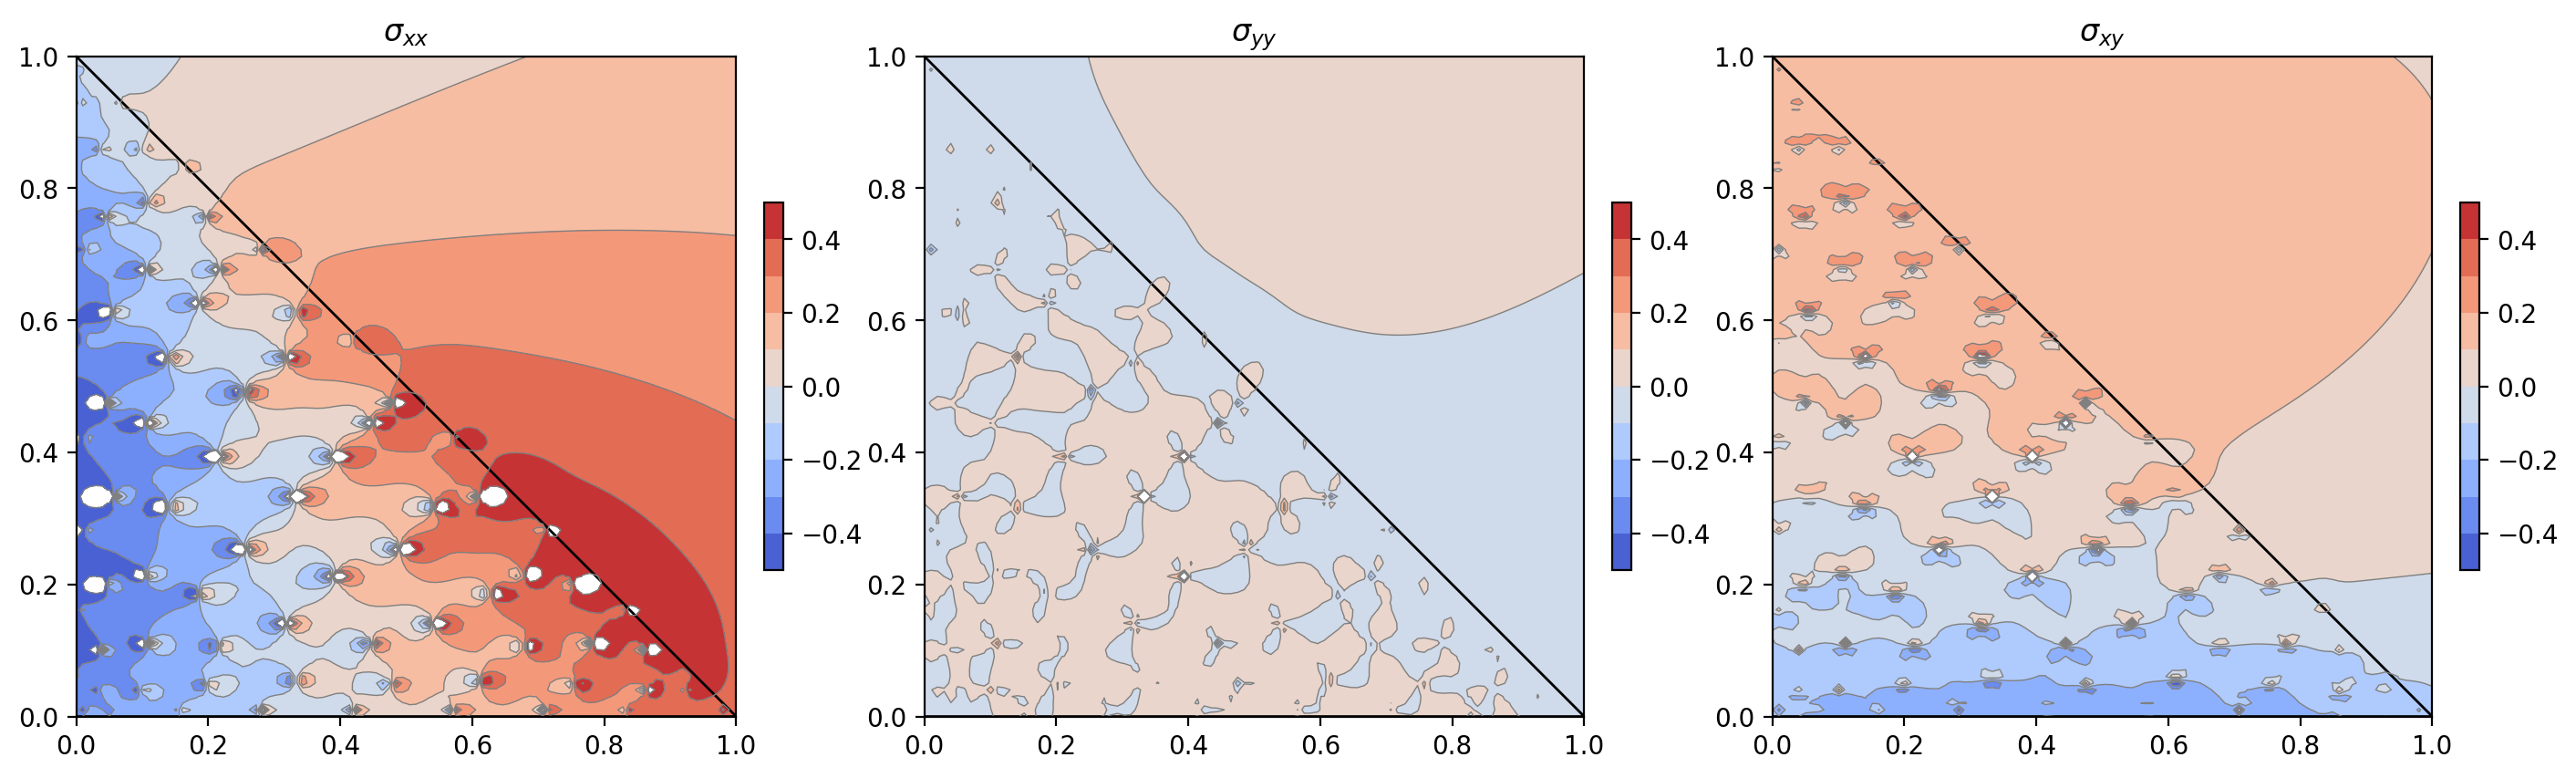

In [23]:
LINEWIDTH = 0.5
LEVELS = np.linspace(-0.5, 0.5, 11)

plt.figure(figsize=(17, 10))


def plot_stresses(x_grid, y_grid, stresses, triangle, title_string):
    plt.contourf(
        x_grid,
        y_grid,
        stresses,
        cmap="coolwarm",
        levels=LEVELS,
    )
    plt.colorbar(fraction=0.026, pad=0.04, extend="both")
    plt.clim([-0.5, 0.5])
    plt.contour(
        x_grid,
        y_grid,
        stresses,
        colors="gray",
        linestyles="solid",
        linewidths=LINEWIDTH,
        levels=LEVELS,
    )
    plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
    plt.title(title_string)
    plt.gca().set_aspect("equal")
    plt.xlim([np.min(triangle[:, 0]), np.max(triangle[:, 0])])
    plt.ylim([np.min(triangle[:, 1]), np.max(triangle[:, 1])])


plt.subplot(1, 3, 1)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(kelvin_stresses[:, 0], (n_obs, n_obs)),
    triangle,
    "$\sigma_{xx}$",
)

plt.subplot(1, 3, 2)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(kelvin_stresses[:, 1], (n_obs, n_obs)),
    triangle,
    "$\sigma_{yy}$",
)

plt.subplot(1, 3, 3)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(kelvin_stresses[:, 2], (n_obs, n_obs)),
    triangle,
    "$\sigma_{xy}$",
)

plt.show()

#### `scipy.integrate.dblquad` integration

The triangle $ABC$ is defined in terms of: 

$A(0,0)$, $B(L_x,dL_y)$, $C(0,L_y)$

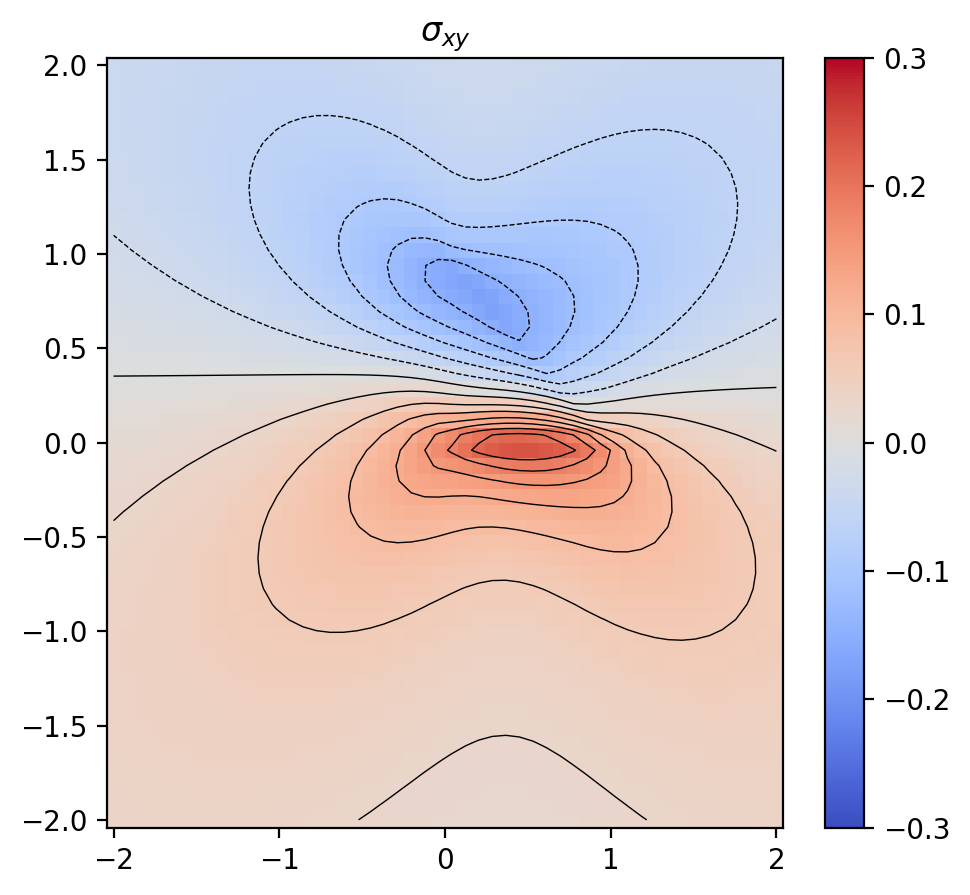

In [22]:
nx_pts = 50
ny_pts = 50

# Define a triangle region
Lx = 1
Ly = 1
dLy = 0.5
dLy = 0.0


# Calculate the lengths of the sides of the triangle
a = np.sqrt((Lx - 0) ** 2 + (dLy - 0) ** 2)
b = np.sqrt((0 - Lx) ** 2 + (Ly - dLy) ** 2)
c = np.sqrt((0 - 0) ** 2 + (0 - Ly) ** 2)

# Calculate the semi-perimeter of the triangle
s = (a + b + c) / 2
# Calculate the area of the triangle using Heron's formula
area_source = np.sqrt(s * (s - a) * (s - b) * (s - c))

# Definition of integration limits over a triangle
ymin = lambda x: dLy * x / Lx
ymax = lambda x: Ly - (Ly - dLy) * x / Lx

x_vec = np.linspace(-2, 2, nx_pts)
y_vec = np.linspace(-2, 2, ny_pts)
xo, yo = np.meshgrid(x_vec, y_vec)
ux = np.zeros_like(xo).flatten()
sxy = np.zeros_like(xo).flatten()
for i in range(0, xo.size):
    f = lambda y, x: kelvin_point_source_disp(
        xo.flatten()[i], yo.flatten()[i], x, y, 1, 0, mu, nu
    )[0]
    sol, err = scipy.integrate.dblquad(f, 0, 1, ymin, ymax, epsabs=1e-2)
    ux[i] = sol / area_source
    f = lambda y, x: kelvin_point_source_stress(
        xo.flatten()[i], yo.flatten()[i], x, y, 1, 0, mu, nu
    )[2]
    sol, err = scipy.integrate.dblquad(f, 0, 1, ymin, ymax, epsabs=1e-3)
    sxy[i] = sol / area_source

plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.contourf(x_vec, y_vec, ux.reshape(ny_pts, nx_pts), levels=20)
# plt.colorbar()
# plt.title("$u_x$")
plt.subplot(1, 2, 2)
plt.pcolor(x_vec, y_vec, sxy.reshape(ny_pts, nx_pts), cmap="coolwarm")
plt.colorbar()
plt.clim([-0.3, 0.3])
plt.contour(
    x_vec,
    y_vec,
    sxy.reshape(ny_pts, nx_pts),
    colors="k",
    linewidths=0.5,
    levels=np.linspace(-0.3, 0.3, 21),
)

plt.title("$\sigma_{xy}$")
plt.show()

# TODO: Near-field vs. far field with shapely buffering?
- https://shapely.readthedocs.io/en/stable/